## Imports

In [37]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## load data

In [2]:
data=pd.read_csv('../data/AdSmartABdata.csv')

## Data visualization

data.head(5)

In [3]:
# number of unique values for aech column
for col in data.columns: print(col,':', data[col].nunique(), 'labels.')

auction_id : 8077 labels.
experiment : 2 labels.
date : 8 labels.
hour : 24 labels.
device_make : 270 labels.
platform_os : 3 labels.
browser : 15 labels.
yes : 2 labels.
no : 2 labels.


### Feature engineering

In [9]:
data['clicked'] = data['yes']+data['no']
data = data[data['clicked'] == 1]

In [5]:
c_data = data[['experiment','date', 'hour', 'device_make', 'platform_os', 'yes']]

In [6]:
x = c_data[['experiment','date', 'hour', 'device_make', 'platform_os']]
y = c_data[['yes']].values
x.shape, y.shape

((1243, 5), (1243, 1))

In [7]:
pro = preprocessing.LabelEncoder()
x['experiment'] = pro.fit_transform(x['experiment'])
x['device_make'] = pro.fit_transform(x['device_make'])
x['date'] = pro.fit_transform(x['date'])
x.sample(5)

,experiment,date,hour,device_make,platform_os
6431,1,5,16,69,6
5738,1,2,12,68,6
16,1,1,16,13,6
7742,1,7,3,13,6
7856,0,4,17,114,5


## Scaling and Normalization

In [8]:
#standardize the data so that exaggerated values don't affect our model(logistic regression)
scaler = MinMaxScaler()
X = scaler.fit_transform(x)
X

array([[1.        , 0.28571429, 0.08695652, 0.03508772, 1.        ],
       [1.        , 0.14285714, 0.69565217, 0.11403509, 1.        ],
       [1.        , 0.42857143, 0.34782609, 0.11403509, 1.        ],
       ...,
       [0.        , 0.85714286, 0.30434783, 0.11403509, 1.        ],
       [0.        , 1.        , 0.69565217, 0.11403509, 1.        ],
       [1.        , 0.        , 0.17391304, 0.11403509, 1.        ]])

## Splitting data

In [12]:
#split data into training, validation and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=25)

## Modeling

In [25]:
!pip install xgboost

     |████████████████████████████████| 166.7 MB 67 kB/s eta 0:00:0121


In [60]:
#Import modeling algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

In [75]:
#import cross_validation library
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5)

### Logistic Regression

In [17]:
#train logistic regression model
logistic_reg = LogisticRegression().fit(X_train, y_train)
log_score = logistic_reg.score(X_test, y_test)
print(log_score)

0.5180722891566265


In [41]:
#import log_loss
from sklearn.metrics import log_loss
model = logistic_reg
# predict probabilities
probs = model.predict_proba(X_val)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss using validation data
loss = log_loss(y_val, probs)
print(f'loss: {loss}')

loss: 0.7013916945763125


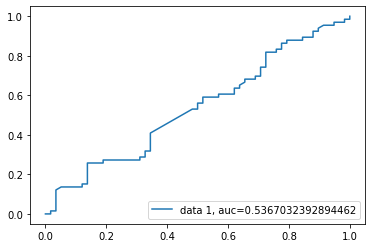

In [43]:
from sklearn import metrics
y_pred_proba = logistic_reg.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

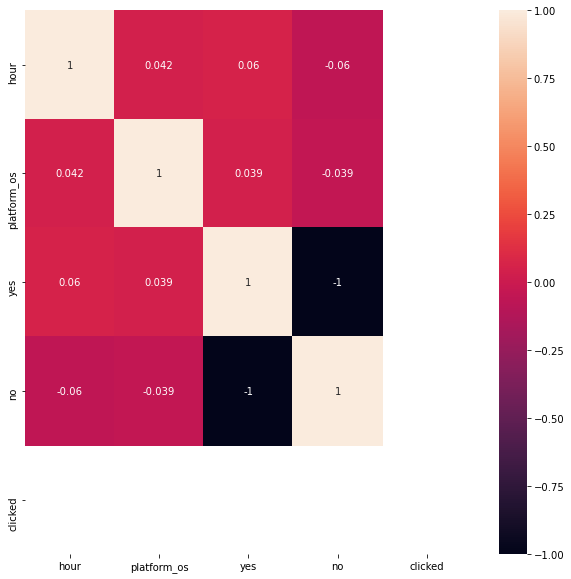

In [23]:
#correlation among the features
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
g = sns.heatmap(data[top_corr_features].corr(), annot= True) #plot heat map

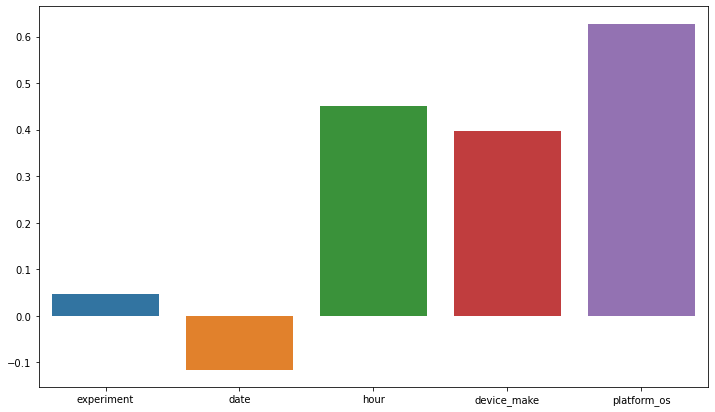

In [20]:
#ploting
plt.figure(figsize=(12,7))
sns.barplot(x.columns, logistic_reg.coef_[0])
plt.show()

### Decision Trees

In [49]:
#train decision tree model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_Score = dtree.score(X_train, y_train)
print(dt_Score)

0.8390804597701149


In [51]:
model = dt
# predict probabilities
probs = model.predict_proba(X_test)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
loss = log_loss(y_test, probs)
loss

12.044930179805037

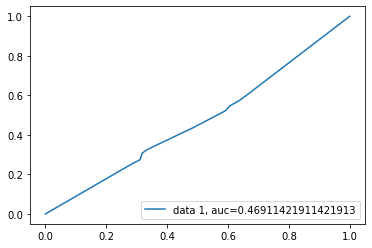

In [52]:
y_pred_proba = dt.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

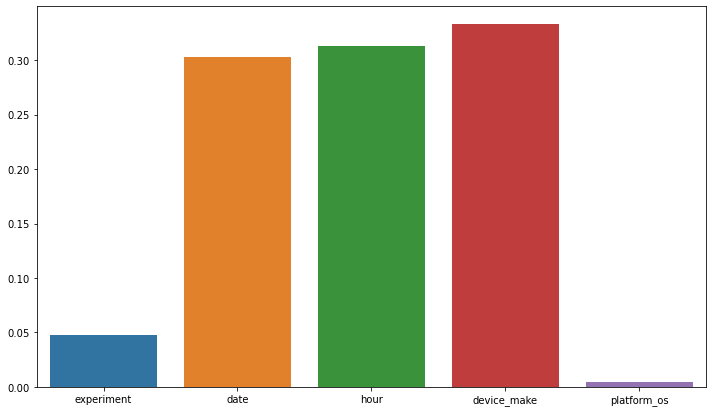

In [53]:
plt.figure(figsize=(12,7))
sns.barplot(x.columns, dtree.feature_importances_)
plt.show()

### XGBoost Classifier

In [64]:
#train XGBoost 
xg = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
xg.score(X_test, y_test)

0.5180722891566265

In [65]:
model = xg
# predict probabilities
probs = model.predict_proba(X_test)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
loss = log_loss(y_test, probs)
loss

0.7125127431040875

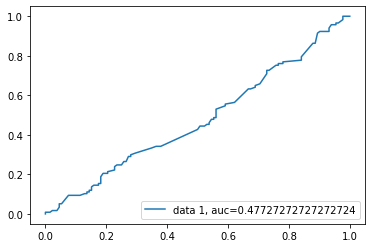

In [66]:
y_pred_proba = xg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

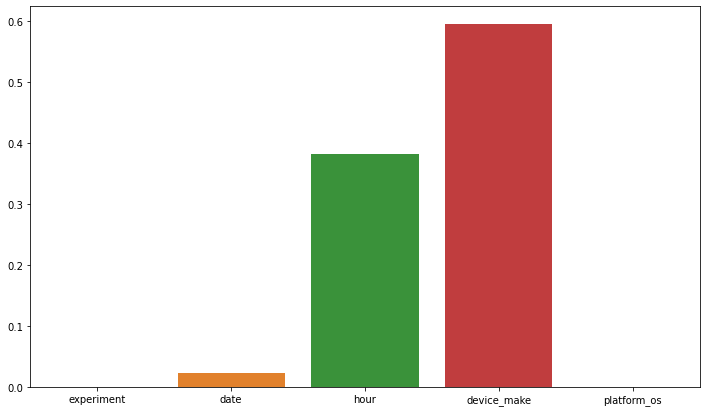

In [67]:
plt.figure(figsize=(12,7))
sns.barplot(x.columns, clf.feature_importances_)
plt.show()

### Kfold

In [78]:
#decision tree kfold
def dk():
    for train_index, test_index in k_fold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        dtree = DecisionTreeClassifier()
        dtree.fit(X_train, y_train)
        print("score:",dtree.score(X_test, y_test))

#logistic kfold
def lk():
    for train_index, test_index in k_fold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        reg = LogisticRegression().fit(X_train, y_train)
        score = reg.score(X_test, y_test)
        print("score:", score)

#XGBoost KFold
def xk():
    for train_index, test_index in k_fold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        dtree = DecisionTreeClassifier()
        dtree.fit(X_train, y_train)
        print(dtree.score(X_test, y_test))
        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
        max_depth=1, random_state=0).fit(X_train, y_train)
        clf.score(X_test, y_test)


In [85]:
print("***** decision tree kfold *****\n____________________________________________")
dk()
print("\n***** logistic kfold *****\n____________________________________________")
lk()
print("\n***** XGBoost KFold *****\n____________________________________________")
xk()

***** decision tree kfold *****
____________________________________________
score: 0.5381526104417671
score: 0.5060240963855421
score: 0.5100401606425703
score: 0.47580645161290325
score: 0.5604838709677419

***** logistic kfold *****
____________________________________________
score: 0.5421686746987951
score: 0.5020080321285141
score: 0.5421686746987951
score: 0.5282258064516129
score: 0.5362903225806451

***** XGBoost KFold *****
____________________________________________
0.5301204819277109
0.5100401606425703
0.5020080321285141
0.4879032258064516
0.5725806451612904
